In [50]:
import pandas as pd
from sqlalchemy import create_engine

# Bağlantı bilgileri
kullanici_adi = "postgres"
sifre = "1234"
host = "localhost"
port = "5433"
veritabani = "Capstone_Project"

engine = create_engine(f"postgresql+psycopg2://{kullanici_adi}:{sifre}@{host}:{port}/{veritabani}")

# PostgreSQL'deki public şemadaki tüm tablo adlarını al
tables_query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public' AND table_type = 'BASE TABLE';
"""
tables_df = pd.read_sql(tables_query, engine)
table_names = tables_df["table_name"].tolist()

# Tüm tabloları DataFrame olarak bir sözlükte tut
all_tables = {}

for table in table_names:
    df = pd.read_sql(f'SELECT * FROM "{table}"', engine)
    all_tables[table] = df
    print(f"✔️ {table} tablosu yüklendi ({df.shape[0]} satır)")


✔️ categories tablosu yüklendi (8 satır)
✔️ customercustomerdemo tablosu yüklendi (0 satır)
✔️ customerdemographics tablosu yüklendi (0 satır)
✔️ customers tablosu yüklendi (91 satır)
✔️ employees tablosu yüklendi (9 satır)
✔️ employeeterritories tablosu yüklendi (49 satır)
✔️ order_details tablosu yüklendi (2155 satır)
✔️ orders tablosu yüklendi (830 satır)
✔️ products tablosu yüklendi (77 satır)
✔️ region tablosu yüklendi (4 satır)
✔️ shippers tablosu yüklendi (6 satır)
✔️ shippers_tmp tablosu yüklendi (6 satır)
✔️ suppliers tablosu yüklendi (29 satır)
✔️ territories tablosu yüklendi (53 satır)
✔️ usstates tablosu yüklendi (51 satır)


In [51]:
import pandas as pd

df_categories = pd.read_sql_query("SELECT * FROM categories", con=engine)
df_customercustomerdemo = pd.read_sql_query("SELECT * FROM customercustomerdemo", con=engine)
df_customerdemographics = pd.read_sql_query("SELECT * FROM customerdemographics", con=engine)
df_customers = pd.read_sql_query("SELECT * FROM customers", con=engine)
df_employees = pd.read_sql_query("SELECT * FROM employees", con=engine)
df_employeeterritories = pd.read_sql_query("SELECT * FROM employeeterritories", con=engine)
df_order_details = pd.read_sql_query("SELECT * FROM order_details", con=engine)
df_orders = pd.read_sql_query("SELECT * FROM orders", con=engine)
df_products = pd.read_sql_query("SELECT * FROM products", con=engine)
df_region = pd.read_sql_query("SELECT * FROM region", con=engine)
df_shippers = pd.read_sql_query("SELECT * FROM shippers", con=engine)
df_shippers_tmp = pd.read_sql_query("SELECT * FROM shippers_tmp", con=engine)
df_suppliers = pd.read_sql_query("SELECT * FROM suppliers", con=engine)
df_territories = pd.read_sql_query("SELECT * FROM territories", con=engine)
df_usstates = pd.read_sql_query("SELECT * FROM usstates", con=engine)

In [52]:
all_tables

{'categories':    category_id   category_name  \
 0            1       Beverages   
 1            2      Condiments   
 2            3     Confections   
 3            4  Dairy Products   
 4            5  Grains/Cereals   
 5            6    Meat/Poultry   
 6            7         Produce   
 7            8         Seafood   
 
                                          description picture  
 0        Soft drinks, coffees, teas, beers, and ales      []  
 1  Sweet and savory sauces, relishes, spreads, an...      []  
 2                Desserts, candies, and sweet breads      []  
 3                                            Cheeses      []  
 4                Breads, crackers, pasta, and cereal      []  
 5                                     Prepared meats      []  
 6                          Dried fruit and bean curd      []  
 7                                   Seaweed and fish      []  ,
 'customercustomerdemo': Empty DataFrame
 Columns: [customer_id, customer_type_id]
 Index: [

In [53]:
df_orders.columns

Index(['order_id', 'customer_id', 'employee_id', 'order_date', 'required_date',
       'shipped_date', 'ship_via', 'freight', 'ship_name', 'ship_address',
       'ship_city', 'ship_region', 'ship_postal_code', 'ship_country'],
      dtype='object')

In [54]:
print(df_order_details.columns.tolist())
print(df_products.columns.tolist())

['order_id', 'product_id', 'unit_price', 'quantity', 'discount']
['product_id', 'product_name', 'supplier_id', 'category_id', 'quantity_per_unit', 'unit_price', 'unit_in_stock', 'unit_on_order', 'reorder_level', 'discontinued']


In [55]:
product_order_data = df_order_details.merge(df_products, on="product_id")
top_products = product_order_data.groupby("product_name")["quantity"].sum().sort_values(ascending=False).head(10)
print(top_products)

product_name
Camembert Pierrot         1577
Raclette Courdavault      1496
Gorgonzola Telino         1397
Gnocchi di nonna Alice    1263
Pavlova                   1158
Rhönbräu Klosterbier      1155
Guaraná Fantástica        1125
Boston Crab Meat          1103
Tarte au sucre            1083
Chang                     1057
Name: quantity, dtype: int64


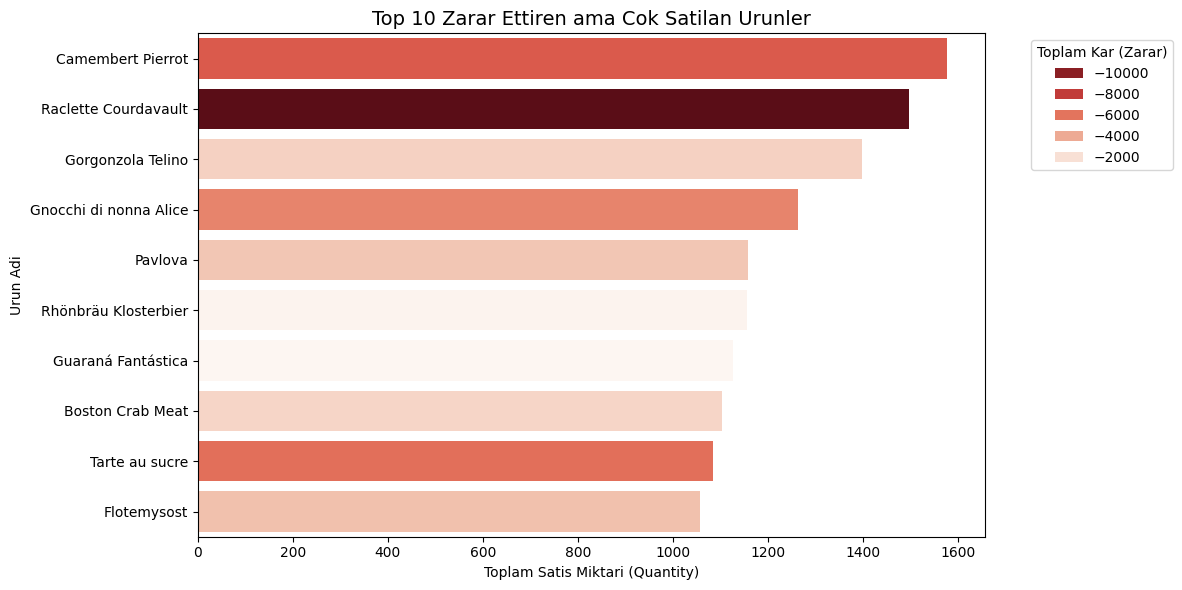

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Merge islemi
merged = df_order_details.merge(df_products, on="product_id")

# hesaplamalar
merged["real_price"] = merged["unit_price_x"] * (1 - merged["discount"])
merged["catalog_price"] = merged["unit_price_y"]
merged["margin_per_unit"] = merged["real_price"] - merged["catalog_price"]
merged["total_profit"] = merged["margin_per_unit"] * merged["quantity"]

# urun bazinda grup
product_stats = merged.groupby("product_name").agg({
    "quantity": "sum",
    "total_profit": "sum"
}).reset_index()

# zarar eden ve cok satilan 10 urun
filtered = product_stats[(product_stats["total_profit"] < 0)]
top10_loss = filtered.sort_values("quantity", ascending=False).head(10)

# gorsellestirme
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_loss,
    x="quantity",
    y="product_name",
    hue="total_profit",
    dodge=False,
    palette="Reds_r"
)
#
plt.title("Top 10 Zarar Ettiren ama Cok Satilan Urunler", fontsize=14)
plt.xlabel("Toplam Satis Miktari (Quantity)")
plt.ylabel("Urun Adi")
plt.legend(title="Toplam Kar (Zarar)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **_Neden Bu Cok Satan Urunler Zararda?_**

Grafikte gosterilen bu 10 urun, cok miktarda satilmis, ama sirket icin zarar ettirmis.

Yani:
* 	Satis ekibi bu urunleri bol bol satmis
* 	Ama sirketin kasasina para girmemis, hatta eksiye dusulmus

**_Bu da su soruyu akla getiriyor:_**

“Bazi urunler sadece satilmak icin mi satiliyor — zararina bile olsa?”

**_Muhtemel nedenler:_**
* 	Buyuk ihtimalle promosyonlarda on planda yer aldi
* 	Paket (bundle) satislarda sunulmus olabilir
* 	Ya da stok fazlasi oldugu icin zararina satilmis

**_Aslinda bazi urunler bilerek zararina satilir, cunku:_**
* 	Yeni musteriler cekmek icin kullanilir (Loss Leader Strategy)
* 	Daha pahali urunlerin satisini artirmak icindir
* 	Ya da marka bilinirligini artirmak icin dusuk fiyattan sunulur



/var/folders/g2/sr45sq6x6m74bpy8r89t4yvh0000gn/T/ipykernel_35636/1327783596.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


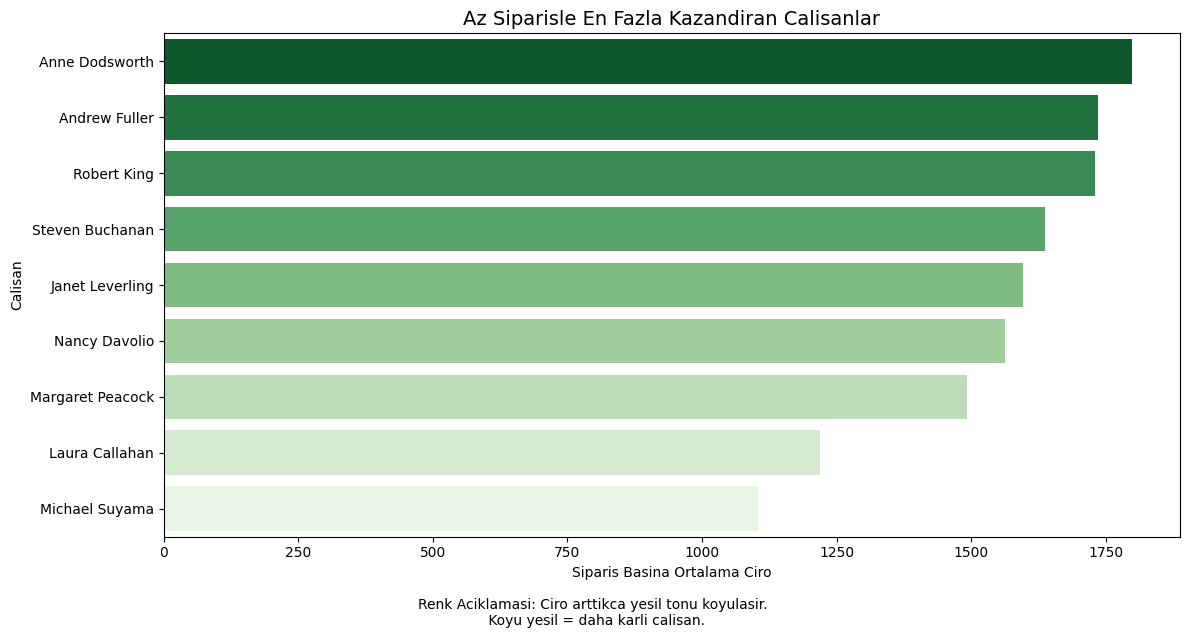

In [64]:
# En cok kar ettiren calisan ama en az siparis alan kisi kim?

import matplotlib.pyplot as plt
import seaborn as sns

# birlesimler
merged = df_order_details.merge(df_orders, on="order_id").merge(df_employees, on="employee_id")

# kar hesaplama
merged["total_price"] = merged["unit_price"] * merged["quantity"] * (1 - merged["discount"])

# calisan bazinda siparis ve kazanc
employee_perf = merged.groupby("employee_id").agg({
    "order_id": "nunique",   # aldığı sipariş sayısı
    "total_price": "sum"     # getirdiği toplam ciro
}).reset_index()

# kar/siparis orani
employee_perf["profit_per_order"] = employee_perf["total_price"] / employee_perf["order_id"]

# en yuksek kazanc/siparis oranina sahip 10 kisi
top10_eff = employee_perf.sort_values("profit_per_order", ascending=False).head(10)
# isim belirleme
top10_eff = top10_eff.merge(df_employees[["employee_id", "first_name", "last_name"]], on="employee_id")
top10_eff["full_name"] = top10_eff["first_name"] + " " + top10_eff["last_name"]

# gorsellestirme
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_eff,
    x="profit_per_order",
    y="full_name",
    palette="Greens_r"
)
plt.figtext(0.5, -0.05, "Renk Aciklamasi: Ciro arttikca yesil tonu koyulasir. \n Koyu yesil = daha karli calisan.", ha="center", fontsize=10)
plt.title("Az Siparisle En Fazla Kazandiran Calisanlar", fontsize=14)
plt.xlabel("Siparis Basina Ortalama Ciro")
plt.ylabel("Calisan")
plt.tight_layout()
plt.show()

## **_Grafik ne anlatiyor?_**

 **_Burada kimin gercekten kaliteli ve kazancli isler aldigini gorecegiz._**

Grafikteki urunler, satis adedi en yuksek 10 urunu temsil ediyor.
Yani bu urunler en cok siparis verilen urunler olmus.

Ancak satis miktarinin yuksek olmasi her zaman kar getirmemis.
Bazi urunler, cok satilmasina ragmen negatif total profit degerine sahip.

**Bu da su anlama gelebilir:**

* 	Fiyati cok dusukten satilmis olabilir,
* 	Indirim orani asiri derecede yuksek,
* 	Veya zaten maliyeti yuksek bir urun olabilir.

Mesela grafikte, cok satan ama bariz zarar ettiren bir urun varsa, bu fiyatlandirma stratejimizde bir problem oldugunu gosterir.

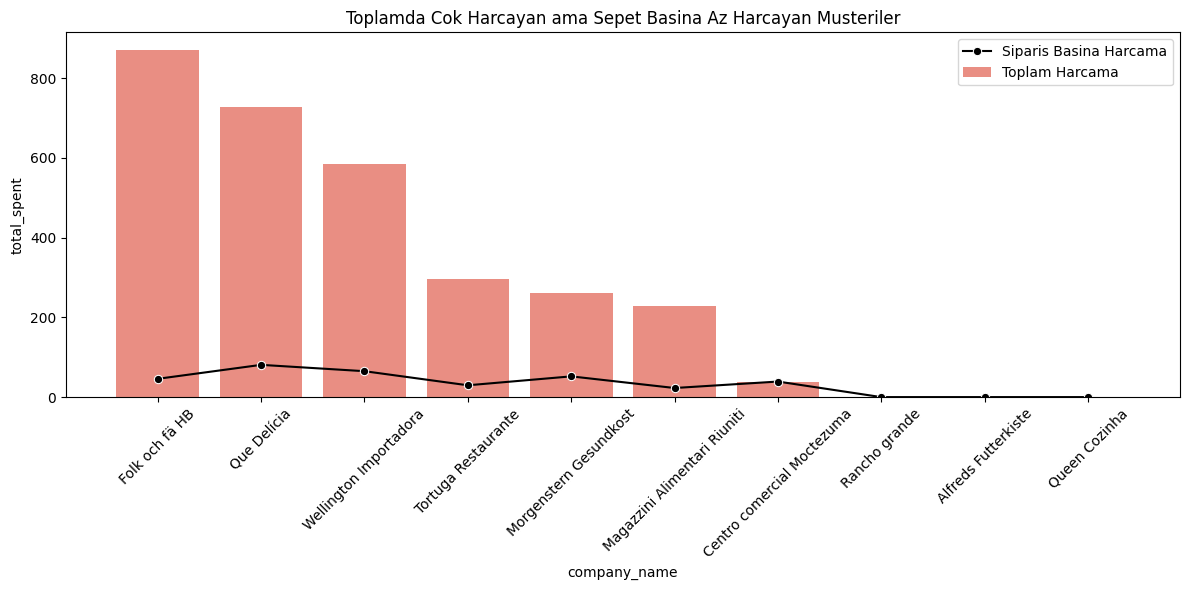

In [60]:
# order_details + orders + custormer
customer_orders = df_order_details.merge(df_orders, on="order_id") \
                                  .merge(df_customers, on="customer_id") \
                                  .merge(df_products, on="product_id")
# toplam harcama
customer_orders["total_price"] = df_products["unit_price"] * df_order_details["quantity"] * (1 - df_order_details["discount"])

# musteri bazinda analiz
customer_summary = customer_orders.groupby(["customer_id", "company_name"]).agg(
    total_spent=("total_price", "sum"),
    total_orders=("order_id", "nunique")
).reset_index()

# siparis basina ortalama harcama
customer_summary["avg_spent_per_order"] = customer_summary["total_spent"] / customer_summary["total_orders"]

# en cok harcayan ama siparis basina dusuk harcayanlar
insightful_customers = customer_summary.sort_values(by="total_spent", ascending=False)
insightful_customers = insightful_customers[insightful_customers["avg_spent_per_order"] < 100]

# ilk 10 musteri
top10_interesting_customers = insightful_customers.head(10)

# gorswellestirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_interesting_customers,
            x="company_name", y="total_spent", color='salmon', label='Toplam Harcama')
sns.lineplot(data=top10_interesting_customers,
             x="company_name", y="avg_spent_per_order", color='black', marker='o', label='Siparis Basina Harcama')

plt.title("Toplamda Cok Harcayan ama Sepet Basina Az Harcayan Musteriler")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **_Bu grafik ne anlatiyor?_**

Bu grafik “Toplamda cok harcayan ama sepet basi harcamasi dusuk olan musterileri” gösteriyor.

 ### Grafik Bilesenleri:
	1.Kirmizi Barlar: Her bir musterinin toplam harcamasi (total_spent)
	2.Siyah Nokta-Cizgi: Her bir musterinin bir sipariste ortalama ne kadar harcadigi (avg_spent_per_order)


**_Folk och fä HB gibi firmalar:_**
* 	Toplam harcama cok yuksek ama sepet basi harcama cok dusuk.
* 	Bu su demek: Bu musteri bircok kucuk siparis vermis.
* 	Onlara ozel “paket kampanyasi”, “daha fazla al, daha az ode” turu teklifler sunulabilir.
* 	Satis frekansi yuksek ama birim basi gelir az → cross-sell / bundle firsati var.

**_Que Delícia ve Wellington Importadora:_**
* 	Hem toplam harcama yuksek, hem sepet basina harcama fena degil.
* 	Bunlar “altin musteriler”. Sadakat programina alinabilir.
* 	Daha yuksek kar biraktirmak icin premium urun onerilebilir.


**_Rancho grande, Alfreds Futterkiste, Queen Cozinha:_**
* 	Sepet basina harcama da dusuk, toplam harcama da dusuk.
* 	Bunlar buyuk ihtimalle ya yeni ya da pasif musteriler.
* 	Ozel kampanya ya da yeniden etkilesim (retargeting) uygulanabilir.
